###  np.reshape

In [3]:
import numpy as np
a = np.array([1,2,3,4])
print(a.shape)
print(a.T)

(4,)
[1 2 3 4]


In [4]:
import numpy as np
a = np.array([1,2,3,4])
print(a.shape)
print(a.reshape(4,1))

(4,)
[[1]
 [2]
 [3]
 [4]]


### axis=0, axis=1

In [5]:
import numpy as np
a = np.arange(8).reshape(2,4)
print(a)
print(np.sum(a, axis=1))
print(np.sum(a, axis=0))

[[0 1 2 3]
 [4 5 6 7]]
[ 6 22]
[ 4  6  8 10]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [7]:
class SingleLayer:    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다.
        return z

    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(x)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = a - y                   # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [8]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err, axis=0) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = (a - y)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [9]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

In [10]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size     # 배치 크기
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)     # 타깃을 열 벡터로 바꿉니다.
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        np.random.seed(42)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1) # 타깃을 열 벡터로 바꿉니다.
                m = len(x_batch)                 # 샘플 개수를 저장합니다.
                a = self.training(x_batch, y_batch, m)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

In [11]:
a = np.array([4,3,5,6,2,7,1])
y = np.array([0,0,0,0,0,0,1])
print(np.max(a))
print(np.argmax(a))
print(np.argmax(a) == np.argmax(y))

7
5
False


In [12]:
a = np.array([[4,3,5,6,2,7,1],
              [3,4,7,5,6,2,1]])
y = np.array([[0,0,0,0,0,1,0],
              [0,0,0,1,0,0,0]])
print(np.argmax(a, axis=1))
print( np.mean(np.argmax(a, axis=1) == np.argmax(y, axis=1)))

[5 2]
0.5


In [13]:
class MultiClassNetwork(MinibatchNetwork):
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = (a - y)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))


In [16]:
!pip3 install tensorflow

     |████████████████████████████████| 458.3 MB 13.0 MB/s            
     |████████████████████████████████| 65 kB 43.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 42 kB 40.5 MB/s            
     |████████████████████████████████| 1.1 MB 20.8 MB/s            
     |████████████████████████████████| 1.3 MB 28.6 MB/s            
     |████████████████████████████████| 5.6 MB 11.7 MB/s            
     |████████████████████████████████| 462 kB 31.3 MB/s            
     |████████████████████████████████| 4.0 MB 47.7 MB/s            
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.0 MB 23.9 MB/s            
     |████████████████████████████████| 57 kB 33.2 MB/s            
     |████████████████████████████████| 132 kB 21.3 MB/s            
     |████████████████████████████████| 781 kB 26.2 MB/s            
     |████████████████████████████████| 97 kB 29.8

      Successfully uninstalled six-1.16.0
  Attempting uninstall: requests
    Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Attempting uninstall: wheel
    Found existing installation: wheel 0.30.0
    Uninstalling wheel-0.30.0:
      Successfully uninstalled wheel-0.30.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.0.0
    Uninstalling protobuf-3.0.0:
      Successfully uninstalled protobuf-3.0.0


In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [18]:
print(x_train_all.shape, y_train_all.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [19]:
print(x_train_all.shape)
print(x_train_all[0].shape)

(60000, 28, 28)
(28, 28)


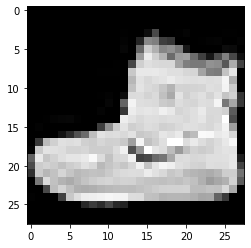

In [20]:
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [21]:
print(y_train_all[:100])

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6 6 7 9 5 9 2 7 3 0 3 3 3 7 2 2 6 6 8 3 3 5 0 5 5 0 2 0 0 4 1 3 1 6 3
 1 4 4 6 1 9 1 3 5 7 9 7 1 7 9 9 9 3 2 9 3 6 4 1 1 8]


드레스


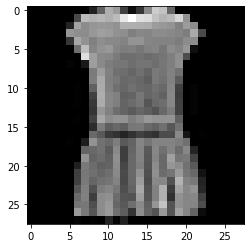

In [22]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', 
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
index = 3
print(class_names[y_train_all[index]])
# plt.title(class_names[y_train_all[index]])
plt.imshow(x_train_all[index], cmap='gray')
plt.show()

#### np.bincount 예제

In [23]:
a = np.array([0,1,1,0,0,0,0,1,1,0])
print(len(a))
print(a.shape[0])
print(np.bincount(a))

10
10
[6 4]


In [24]:
a = np.array([0,4,4,1,2,3,3,3,3,4,5,0,6,6])
print(len(a))
print(a.shape[0])
print(np.bincount(a))

14
14
[2 1 1 4 3 1 2]


In [25]:
print(len(y_train_all))
print(np.bincount(y_train_all))

60000
[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


In [26]:
print(len(y_test))
print(np.bincount(y_test))

10000
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


In [27]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [28]:
print(len(y_train))
np.bincount(y_train)

48000


array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [29]:
print(len(y_val))
np.bincount(y_val)

12000


array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [30]:
print(x_train.shape)
print(x_train[0].shape)  # (48000,28,28)
print(x_train[0])

(48000, 28, 28)
(28, 28)
[[  0   0   0   0   1   1   0   0   0  25  55   0   0   0   0   0   0  43
   24   0   0   0   1   0   0   0   0   0]
 [  0   0   0   1   1   1   0  25 147 189 181  96  51  49  55  37  76 217
  172 125  20   0   2   1   0   0   0   0]
 [  0   0   0   1   3   0  82 206 202 190 178 188 239 152  99 199 201 162
  176 192 185  71   0   2   0   0   0   0]
 [  0   0   0   1   0   0 202 196 181 188 183 169 179 160 107 198 166 167
  178 170 183 166   0   0   1   0   0   0]
 [  0   0   0   1   0  48 216 184 185 185 190 175 164 188 198 188 157 183
  176 171 167 175  26   0   2   0   0   0]
 [  0   0   0   0   0  90 224 183 185 184 183 190 164 169 193 158 170 174
  176 175 165 180  62   0   0   0   0   0]
 [  0   0   0   0   0 123 228 184 180 183 178 183 172 172 172 161 179 170
  174 175 165 181 106   0   0   0   0   0]
 [  0   0   0   0   0 156 229 188 175 178 175 175 190 157 157 180 169 169
  172 171 161 179 143   0   0   0   0   0]
 [  0   0   0   0   0 181 228 190 174 1

###  표준화(standardization)

In [31]:
x_train = x_train / 255
x_val = x_val / 255

In [32]:
print(np.max(x_train))
print(np.min(x_train))
print(np.mean(x_train))
print(np.std(x_train))

1.0
0.0
0.2862528489520806
0.3531738779381928


In [33]:
print(x_train[0])

[[0.         0.         0.         0.         0.00392157 0.00392157
  0.         0.         0.         0.09803922 0.21568627 0.
  0.         0.         0.         0.         0.         0.16862745
  0.09411765 0.         0.         0.         0.00392157 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.00392157 0.00392157
  0.         0.09803922 0.57647059 0.74117647 0.70980392 0.37647059
  0.2        0.19215686 0.21568627 0.14509804 0.29803922 0.85098039
  0.6745098  0.49019608 0.07843137 0.         0.00784314 0.00392157
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.01176471 0.
  0.32156863 0.80784314 0.79215686 0.74509804 0.69803922 0.7372549
  0.9372549  0.59607843 0.38823529 0.78039216 0.78823529 0.63529412
  0.69019608 0.75294118 0.7254902  0.27843137 0.         0.00784314
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00392157 0.         0.
  0.7921

In [34]:
print(x_train.shape)

(48000, 28, 28)


In [35]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [36]:
y_train[0]

6

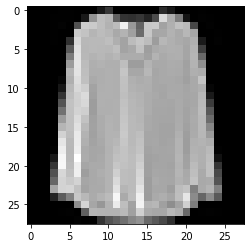

In [37]:
plt.imshow(x_train[0].reshape(28,28), cmap='gray')
plt.show()

In [38]:
tf.keras.utils.to_categorical([0, 1, 3]) # 원 핫 인코딩

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [39]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [40]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


........................................

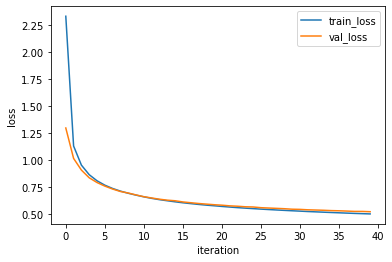

In [41]:
fc = MultiClassNetwork(units=100, batch_size=256) # x_train_batch.shape = (256,784) w1.shape=(784,100)
                                                  # b1.shape = (100,)
                                                  # a1.shape = (256,100) , w2.shape = (100,10)
                                                  # b2.shape = (10,) , a2.shape(256,10)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### 값 예측하기

(1, 784)
예측값: 6
셔츠
실제값: 6
셔츠


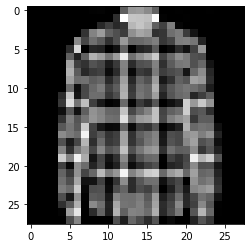

In [43]:
index = 7
x = x_test[index:index+1].reshape(1,784)
print(x.shape)
x = x/255.
x
y_pred = fc.predict(x)
print("예측값:", y_pred[0])
print(class_names[y_pred[0]])
print("실제값:", y_test[index])
print(class_names[y_test[index]])
plt.imshow(x_test[index], cmap='gray')
plt.show()

### 모델 평가하기

In [44]:
x_scaled = x_test/255.
y_test_encoded = tf.keras.utils.to_categorical(y_test)
x = x_scaled.reshape(-1,784)
score = fc.score(x, y_test_encoded)
print(score)

0.7997


### 다중 분류 케라스로 구현하기

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))  # w1.shape = (784,100), b1.shape=(100,)
model.add(Dense(10, activation='softmax'))           # w2.shape=(100,10), b2.shape=(10,)
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train_encoded, epochs=40, 
                    validation_data=(x_val, y_val_encoded))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()


Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 1.3708 - accuracy: 0.6454 - val_loss: 0.9568 - val_accuracy: 0.7283
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8439 - accuracy: 0.7379 - val_loss: 0.7539 - val_accuracy: 0.7549
Epoch 3/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.7164 - accuracy: 0.7612 - val_loss: 0.6687 - val_accuracy: 0.7738
Epoch 4/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6515 - accuracy: 0.7763 - val_loss: 0.6168 - val_accuracy: 0.7908
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6092 - accuracy: 0.7907 - val_loss: 0.5814 - val_accuracy: 0.8006
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5790 - accuracy: 0.8002 - val_loss: 0.5542 - val_accuracy: 0.8084
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5556 - accuracy: 0.8078 - val_loss: 0.5338 - val_accuracy:

In [ ]:
model.summary()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

### 합성곱 신경망(CNN)

In [ ]:
import numpy as np
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])
w = np.array([2, 1, 5, 3])

In [ ]:
w_r = w[::-1]
print(w_r)

In [ ]:
w_r = np.flip(w)
print(w_r)

In [ ]:
N = len(x)
F = len(w_r)
O = N - F + 1
for i in range(O):
#     print(np.dot(x[i:i+4], w_r.reshape(-1,1)), end=' ')  # (4,)(4,1) => (1,)
#   print(np.dot(x[i:i+4], w_r), end=' ')  # (4,)(4,) => () 스칼라
   print(np.sum(x[i:i+4]*w_r), end=' ')  # (4,)(4,) => () 스칼라


In [ ]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

In [ ]:
from scipy.signal import correlate
correlate(x, w, mode='valid')

In [ ]:
from scipy.signal import correlate
correlate(x, w, mode='full')

In [ ]:
from scipy.signal import correlate
correlate(x, w, mode='same')

In [ ]:
import numpy as np
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

In [ ]:
x = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
w = np.array([[2, 0], [0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode='same')

In [ ]:
x = np.arange(7*7).reshape(7,7)
print(x)
w = np.ones((3,3))
print(w)
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

### 렐루 함수

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0,x)

# x = np.array([-1,3,4,5,-2,3,4,5])
# y = relu(x)
# print(y)

x = np.arange(-5, 5, 0.01)
y = relu(x)
plt.plot(x,y)
plt.show()

### 합성곱 연산

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
image = tf.constant([[[[1],[2],[3]],
                      [[4],[5],[6]],
                      [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)
print(image)
print(image.numpy())
print(image.numpy().reshape(3,3).shape)
print(image.numpy().reshape(3,3))
plt.imshow(image.numpy().reshape(3,3), cmap='gray')
plt.show()

In [ ]:
weight = np.array([[[[1.]], [[1.]]],[[[1.]],[[1.]]]])
print("weight.shape=", weight.shape) # (height, width, channel, FN)

In [ ]:
weight_init = tf.constant_initializer(weight)
# print(type(weight_init))
conv2d = tf.keras.layers.Conv2D(filters=1, kernel_size=2, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape) # N-F+1=O  (1,2,2,1)
print(conv2d.numpy())
print(conv2d.numpy().reshape(2,2))
plt.imshow(conv2d.numpy().reshape(2,2), cmap='gray')
plt.show()

In [ ]:
weight_init = tf.constant_initializer(weight)
# print(type(weight_init))
conv2d = tf.keras.layers.Conv2D(filters=1, kernel_size=2, padding='same', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape) # N-F+1=O  (1,2,2,1)
print(conv2d.numpy())
print(conv2d.numpy().reshape(3,3))
plt.imshow(conv2d.numpy().reshape(3,3), cmap='gray')
plt.show()

In [ ]:
image = tf.constant([[[[1],[2],[3]],
                      [[4],[5],[6]],
                      [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)

In [ ]:
weight = np.array([[[[1.,10.,-1.]],[[1.,10.,-1.]]],[[[1.,10.,-1.]],[[1.,10.,-1.]]]])
print(weight.shape)  # (height, width, channel, FN)
print(weight)
temp=np.transpose(weight,(3,0,1,2))
for t in temp:
    print(t.reshape(2,2))

In [ ]:
weight_init = tf.constant_initializer(weight)
conv2d = tf.keras.layers.Conv2D(filters=3, kernel_size=2, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)  # (1,2,2,3)
print(conv2d)

feature_maps = np.swapaxes(conv2d, 0, 3)
print(feature_maps.shape)

for i, feature_map in enumerate(feature_maps):
    print(feature_map.reshape(2,2))
    plt.subplot(1,3,i+1), plt.imshow(feature_map.reshape(2,2), cmap='gray')
plt.show()

In [ ]:
weight_init = tf.constant_initializer(weight)
conv2d = tf.keras.layers.Conv2D(filters=3, kernel_size=2, padding='same', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)
# print(conv2d)

feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    print(feature_map.reshape(3,3))
#     plt.subplot(1,3,i+1), plt.imshow(feature_map.reshape(3,3), cmap='gray')
# plt.show()

In [ ]:
image = tf.constant(  [[ 
                         [[1,0,1],[1,1,1],[1,1,1],[0,0,1],[0,1,0]], 
                         [[0,0,1],[1,1,1],[1,1,1],[1,1,1],[0,0,0]], 
                         [[0,0,0],[0,0,0],[1,1,0],[1,1,1],[1,0,1]], 
                         [[0,0,0],[0,0,1],[1,1,1],[1,1,1],[0,1,0]], 
                         [[0,1,0],[1,1,1],[1,1,1],[0,0,0],[0,0,0]] 
                      ]],     dtype=np.float32)
print(image.shape)

In [ ]:
maps = np.swapaxes(image, 0, 3)
print(maps.shape)
for i, map in enumerate(maps):
    print(map.reshape(5,5))

In [ ]:
weight = np.array( [ 
                     [[[1],[0],[-1]], [[0],[-1],[0]], [[1],[0],[0]]],
                     [[[0],[-1],[0]], [[1],[1],[1]], [[0],[-1],[0]]],
                     [[[1],[1],[0]], [[0],[-1],[0]], [[1],[0],[-1]]]
                   ] )

print(weight.shape)
# maps = np.swapaxes(weight, 1, 2)
# maps = np.swapaxes(maps, 0, 1)

maps = np.transpose(weight,(2,0,1,3))

for i, map in enumerate(maps):
    print(map.reshape(3,3))

In [ ]:
weight_init = tf.constant_initializer(weight)
conv2d = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)
feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    print(feature_map.reshape(3,3))

In [ ]:
weight = np.array( [ 
                     [[[1,1],[0,1],[-1,-1]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[0,0]]],
                     [[[0,0],[-1,0],[0,0]], [[1,1],[1,1],[1,1]], [[0,0],[-1,0],[0,0]]],
                     [[[1,1],[1,1],[0,0]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[-1,-1]]]
                   ] )

print(weight.shape)  # (3,3,3,2)
maps = np.swapaxes(weight, 1, 2)
maps = np.swapaxes(maps, 0, 1)

for map in maps:
    map = np.swapaxes(map, 1, 2)
    map = np.swapaxes(map, 0, 1)
    for filter in map:
        print(filter)

In [ ]:
# (3,3,3,2) => (3,2,3,3)
weight = np.array( [ 
                     [[[1,1],[0,1],[-1,-1]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[0,0]]],
                     [[[0,0],[-1,0],[0,0]], [[1,1],[1,1],[1,1]], [[0,0],[-1,0],[0,0]]],
                     [[[1,1],[1,1],[0,0]], [[0,0],[-1,0],[0,0]], [[1,1],[0,1],[-1,-1]]]
                   ] )

maps = np.transpose(weight, (2,3,0,1) )

for map in maps:
    for filter in map:
        print(filter)

In [ ]:
weight_init = tf.constant_initializer(weight)
conv2d = tf.keras.layers.Conv2D(filters=2, kernel_size=3, padding='valid', kernel_initializer=weight_init)(image)
print("conv2d.shape", conv2d.shape)  # (1,3,3,2)
feature_maps = np.swapaxes(conv2d, 0, 3)
for feature_map in feature_maps:
    print(feature_map.reshape(3,3))

### 고차원 텐서 연습

In [ ]:
a = np.arange(12).reshape(3,2,2)
b = np.swapaxes(a, 0, 1)
b

In [ ]:
a = np.arange(12).reshape(3,2,2)
b = np.swapaxes(a, 1, 2)
b

In [ ]:
a = np.arange(12).reshape(3,2,2)
b = np.swapaxes(a, 0, 2)
b

In [ ]:
a = np.arange(24).reshape(2,3,2,2)
b = np.swapaxes(a, 0, 2) 
b

In [ ]:
a = np.arange(24).reshape  (2,3,2,2)
b = np.swapaxes(a, 1, 3) 
b

In [ ]:
image = tf.constant([ [ [ [4], [3] ], [[2],[1]] ] ], dtype=np.float32)
print(image.shape)
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=1, padding='valid')(image)
print(pool.shape)
print(pool.numpy())

### 맥스 풀링 테스트

In [ ]:
image = tf.constant([[[[4],[3]],[[2],[1]]]], dtype=np.float32)
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=1, padding='valid')(image)
print(pool.shape)
print(pool.numpy())


In [ ]:
image = tf.constant([[[[4],[3]],[[2],[1]]]], dtype=np.float32)
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=1, padding='same')(image)
print(pool.shape)
print(pool.numpy())

In [ ]:
image = tf.constant([[[[0],[1],[2],[3]],
                      [[4],[5],[6],[7]],
                      [[8],[9],[10],[11]],
                      [[12],[13],[14],[15]]]], dtype=np.float32)
print(image.shape)
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, padding='valid')(image)
print(pool.shape)
print(pool.numpy())

In [ ]:
mnist = tf.keras.datasets.mnist
class_names = ['0','1','2','3','4','5','6','7','8','9']

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

print(train_images.shape)
img = train_images[0]
plt.imshow( img, cmap='gray')
plt.show()

In [ ]:
img = train_images[0]
img = img.reshape(-1,28,28,1)
img = tf.convert_to_tensor(img)

weight_init = tf.keras.initializers.RandomNormal(stddev=0.01)
conv2d = tf.keras.layers.Conv2D(filters=5, kernel_size=3, padding='same' 
                                , kernel_initializer=weight_init)(img)
print("conv2d.shape", conv2d.shape)  # (1,28,28,5)
feature_maps = np.swapaxes(conv2d, 0, 3)
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1,5,i+1), plt.imshow(feature_map.reshape(28,28), cmap='gray')
plt.show()

In [ ]:
pool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(conv2d)
print(pool.shape)
feature_maps = np.swapaxes(pool, 0, 3)
for i, feature_map in enumerate(feature_maps):
    plt.subplot(1,5,i+1), plt.imshow(feature_map.reshape(14,14), cmap='gray')
plt.show()
